In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
reviews_df = pd.read_csv('fake_reviews_dataset.csv')

# Building a Neural Network

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_and_split_data(df):
    # Load stop words and initialize stemmer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    # Preprocessing function: remove stop words and apply stemming
    def preprocess_text(text):
        words = text.split()
        filtered_words = [stemmer.stem(word) for word in words if word.lower() not in stop_words]
        return ' '.join(filtered_words)

    # Split the data into training and testing sets (80% train, 20% test)
    X = df['text']  # Features (text data)
    y = df['label']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Split into validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Apply preprocessing to the training and testing sets separately
    X_train = X_train.apply(preprocess_text)
    X_test = X_test.apply(preprocess_text)
    X_val = X_val.apply(preprocess_text)

    # Tokenize and pad sequences
    max_words = 40000  # Hardcoded maximum number of words
    max_len = 100      # Hardcoded maximum sequence length
    tokenizer = Tokenizer(num_words=max_words,  oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    X_val_seq = tokenizer.texts_to_sequences(X_val)

    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
    X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')

    # Return the processed datasets and tokenizer
    return X_train_pad, X_test_pad, y_train, y_test, X_val_pad, y_val, tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test, X_val,y_val, tokenizer = preprocess_and_split_data(reviews_df)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Build the LSTM model
model = Sequential([
    Embedding(input_dim=40000, output_dim=64, input_length=100),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),callbacks = [early_stopping])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


811/811 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.5148 - loss: 0.6946 - val_accuracy: 0.4983 - val_loss: 0.6939
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5011 - loss: 0.6937 - val_accuracy: 0.5256 - val_loss: 0.6888
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5825 - loss: 0.6534 - val_accuracy: 0.8021 - val_loss: 0.4540
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7945 - loss: 0.4586 - val_accuracy: 0.8475 - val_loss: 0.3585
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8877 - loss: 0.2926 - val_accuracy: 0.8644 - val_loss: 0.3305
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9105 - loss: 0.2499 - val_accuracy: 0.8782 - val_loss: 0.3055
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9289 - loss: 0.1966 - val_accuracy: 0.8893 - val_loss: 0.3119
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9337 - loss: 0.1841 - val_accurac

In [ ]:
#make predictions on test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, y_pred))
# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4031
           1       0.89      0.87      0.88      4075

    accuracy                           0.88      8106
   macro avg       0.88      0.88      0.88      8106
weighted avg       0.88      0.88      0.88      8106

[[3588  443]
 [ 543 3532]]


In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train = (y_pred_train > 0.5).astype(int)

print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

811/811 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     12948
           1       0.92      0.94      0.93     12988

    accuracy                           0.93     25936
   macro avg       0.93      0.93      0.93     25936
weighted avg       0.93      0.93      0.93     25936

[[11868  1080]
 [  795 12193]]


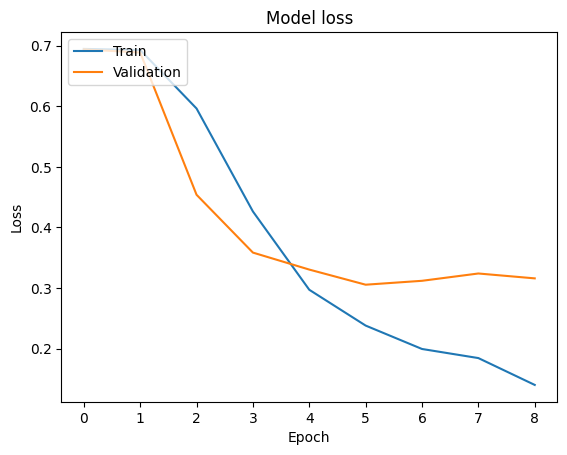

In [ ]:
#Plot train vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

## SHAP

In [ ]:
import shap
import numpy as np
import random

# 1. Define a prediction function for your model
def predict_fn(x):
    return model.predict(x)

# 2. Sample a smaller background set for performance
background_sample = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

# 3. Create the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict_fn, background_sample)

# 4. Select samples to explain
samples_to_explain = X_test[:3]  # Keep small for speed
shap_values = explainer.shap_values(samples_to_explain)

# 5. Decode tokens back to words
index_to_word = {v: k for k, v in tokenizer.word_index.items()}

def decode_tokens(sequence):
    return [index_to_word.get(i, '[PAD]') for i in sequence]  # Don't skip any token


decoded_texts = [decode_tokens(seq) for seq in samples_to_explain]

# 6. Visualize SHAP force plot for each sample
shap.initjs()




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/3 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 90s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 90s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3513/3513 ━━━━━━━━━━━━━━━━━━━━ 91s 26ms/step


In [ ]:
# shap_values[0] has shape (num_samples, num_features)
for i in range(len(samples_to_explain)):
    print(f"\nSample {i+1}: {' '.join(decoded_texts[i])}")
    shap.force_plot(
        explainer.expected_value[0],           # Use [0] because it's a list
        shap_values[0][i],                     # Get the SHAP values for sample i
        feature_names=decoded_texts[i],
        matplotlib=True
    )



Sample 1: interest enough make feel like read book [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


DimensionError: Length of features is not equal to the length of shap_values!

In [ ]:
# prompt: save model

from tensorflow.keras.models import save_model
save_model(model, 'my_model.keras')

In [ ]:
#Load model
from tensorflow.keras.models import load_model
model = load_model('my_model.keras')

ValueError: File not found: filepath=my_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [3]:
pip show transformers


Name: transformers
Version: 4.52.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [4]:
# Import libraries
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

data = reviews_df.copy()

# Preprocess the dataset
data = data[['text', 'label']]  # Use only relevant columns
dataset = Dataset.from_pandas(data)

# Tokenization
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Split the dataset
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Load the pre-trained RoBERTa model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define training parameters
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=8,    # Reduced batch size
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,   # Simulate larger batches
    max_steps=1000,                  # Train over fewer steps
    fp16=True,                       # Use mixed precision
    save_total_limit=1,              # Limit checkpoint storage
    eval_strategy="steps",
    eval_steps=500,
    load_best_model_at_end=True,
    dataloader_num_workers=2         # Reduce workers
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("fine_tuned_roberta")
tokenizer.save_pretrained("fine_tuned_roberta")

# Evaluate the model's performance
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/40526 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-10145ecdcf10>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mvemuri (mvemuri-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
500,0.225400,0.592149
1000,0.105300,0.226771


{'eval_loss': 0.2267707884311676, 'eval_runtime': 55.4561, 'eval_samples_per_second': 146.17, 'eval_steps_per_second': 18.285, 'epoch': 0.4934616333580064}


In [11]:
# prompt: save model to google drive

from google.colab import drive
drive.mount('/content/drive')

# Define the path to save the model in Google Drive
drive_path = '/content/drive/My Drive/fine_tuned_roberta'

# Save the fine-tuned model to Google Drive
trainer.save_model(drive_path)
tokenizer.save_pretrained(drive_path)

print(f"Model saved successfully to {drive_path}")

Mounted at /content/drive
Model saved successfully to /content/drive/My Drive/fine_tuned_roberta


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# prompt: get predictions from model results

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# The predictions variable is a tuple: (predictions, label_ids, metrics)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Print classification report for RoBERTa
print("\nClassification Report (RoBERTa):")
print(classification_report(true_labels, predicted_labels))

# Print confusion matrix for RoBERTa
print("\nConfusion Matrix (RoBERta):")
print(confusion_matrix(true_labels, predicted_labels))


Classification Report (RoBERTa):
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      4058
           1       0.91      0.99      0.95      4048

    accuracy                           0.95      8106
   macro avg       0.95      0.95      0.95      8106
weighted avg       0.95      0.95      0.95      8106


Confusion Matrix (RoBERta):
[[3681  377]
 [  29 4019]]


In [8]:
#Get results on train set
predictions = trainer.predict(train_dataset)

# The predictions variable is a tuple: (predictions, label_ids, metrics)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Print classification report for RoBERTa
print("\nClassification Report (RoBERTa):")
print(classification_report(true_labels, predicted_labels))

# Print confusion matrix for RoBERTa
print("\nConfusion Matrix (RoBERta):")
print(confusion_matrix(true_labels, predicted_labels))


Classification Report (RoBERTa):
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     16174
           1       0.93      0.99      0.96     16246

    accuracy                           0.96     32420
   macro avg       0.96      0.96      0.96     32420
weighted avg       0.96      0.96      0.96     32420


Confusion Matrix (RoBERta):
[[14922  1252]
 [   91 16155]]
